In [25]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.integrate import simpson

In [26]:
def get_slopes(z, sols, n):
    slopes = np.zeros_like(sols)

    # Compute slopes using Lane-Emden equation
    slopes[0] = sols[1]
    slopes[1] = -2/z * sols[1] - sols[0]**n

    return slopes

def lane_emden(n, dz=1e-3, plot=False, z_max=20, method='RK4'):
    u_0 = 1  # change of variables s.t. u = w
    v_0 = 0  # change of variables s.t. v = w'
    z_0 = 1e-6  # initial z value to avoid division by zero
    w_0 = u_0

    ws = np.array([w_0])
    zs = np.array([z_0])

    sols = np.array([u_0, v_0])  # solution vector

    z = z_0

    while z <= z_max:
        if method=="euler":
            slopes = get_slopes(z, sols, n)
        elif method=="RK4":
            k1 = get_slopes(z, sols, n)
            k2 = get_slopes(z + dz/2, sols + k1*dz/2, n)
            k3 = get_slopes(z + dz/2, sols + k2*dz/2, n)
            k4 = get_slopes(z + dz, sols + k3*dz, n)
            slopes = (k1 + 2*k2 + 2*k3 + k4) / 6

        sols = sols + slopes * dz  # update solution vector
        z += dz

        zs = np.append(zs, z)
        ws = np.append(ws, sols[0])
    
    if plot:
        if method=="RK4":
            plt.plot(zs, ws, label=f"RK4, n={n}", linestyle='-')
        elif method=="euler":
            plt.plot(zs, ws, label=f"Euler, n={n}", linestyle='--')

    return zs, ws

/var/folders/6l/y2z2vm4913sb2lzhwp95z6q00000gn/T/ipykernel_48605/3174207499.py:13: RuntimeWarning: overflow encountered in square
  rho_rhoc = ws**n  # compute rho/rhoc


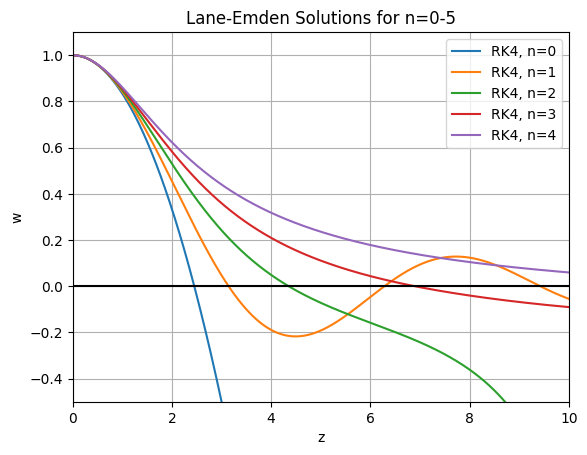

In [32]:
ns = [0, 1, 2, 3, 4]
n5 = 5
Rs = np.zeros_like(ns, dtype=float)
M_ints = np.zeros_like(ns, dtype=float)
I_ints = np.zeros_like(ns, dtype=float)
for i, n in enumerate(ns):
    with warnings.catch_warnings(action="ignore"):
        zs, ws = lane_emden(n, dz=1e-3, plot=True, z_max=20, method='RK4')
    
    # find point where w is closest to 0
    z_zero = np.where(np.isclose(ws, 0, atol=1e-3))[0]
    Rs[i] = zs[z_zero[0]] if z_zero.size > 0 else np.inf
    rho_rhoc = ws**n  # compute rho/rhoc

    # get total mass of sphere by integrating density to Rs[i]
    M_ints[i] = simpson(zs[:z_zero[0]]**2 * ws[:z_zero[0]]**n, zs[:z_zero[0]]) if z_zero.size > 0 else np.inf
    # compute the moment of inertia
    I_ints[i] = simpson(zs[:z_zero[0]]**4 * ws[:z_zero[0]]**n, zs[:z_zero[0]]) if z_zero.size > 0 else np.inf

    # plt.plot(zs[:z_zero[0]], rho_rhoc[:z_zero[0]], label=f"n={n}") if z_zero.size > 0 else plt.plot(zs, rho_rhoc, label=f"n={n} (no zero)")

# n5_maxes = [50, 100, 150, 200, 250, 300, 400, 500]
n5_maxes = [50]
n5_Ms = np.zeros_like(n5_maxes, dtype=float)
n5_Is = np.zeros_like(n5_maxes, dtype=float)
for i, z_max in enumerate(n5_maxes):
    zs, ws = lane_emden(n5, dz=1e-3, plot=False, z_max=z_max, method='RK4')
    n5_Ms[i] = simpson(zs**2 * ws**n5, zs)
    n5_Is[i] = simpson(zs**4 * ws**n5, zs)

plt.ylim(-0.5, 1.1)
plt.xlim(0, 10)
plt.hlines(0, xmin=0, xmax=10, colors='k')
plt.grid()
plt.title("Lane-Emden Solutions for n=0-5")
plt.xlabel("z")
plt.ylabel("w")
plt.legend()
plt.savefig("lane_emden_solutions.png", bbox_inches='tight', dpi=300)
plt.show()

n=0: z_zero=2.449, M_int=4.8901, I_int=17.5828
n=1: z_zero=3.139, M_int=3.1416, I_int=12.1565
n=2: z_zero=4.346, M_int=2.4110, I_int=10.6110
n=3: z_zero=6.874, M_int=2.0182, I_int=10.8516
n=4: z_zero=14.848, M_int=1.7972, I_int=13.6405
n=5, z_max=50: M_int=1.7289, I_int=42.4634
n=5, z_max=100: M_int=1.7313, I_int=53.2510
n=5, z_max=150: M_int=1.7317, I_int=59.5683
n=5, z_max=200: M_int=1.7319, I_int=64.0517
n=5, z_max=250: M_int=1.7319, I_int=67.5296
n=5, z_max=300: M_int=1.7320, I_int=70.3715
n=5, z_max=400: M_int=1.7320, I_int=74.8557
n=5, z_max=500: M_int=1.7320, I_int=78.3340


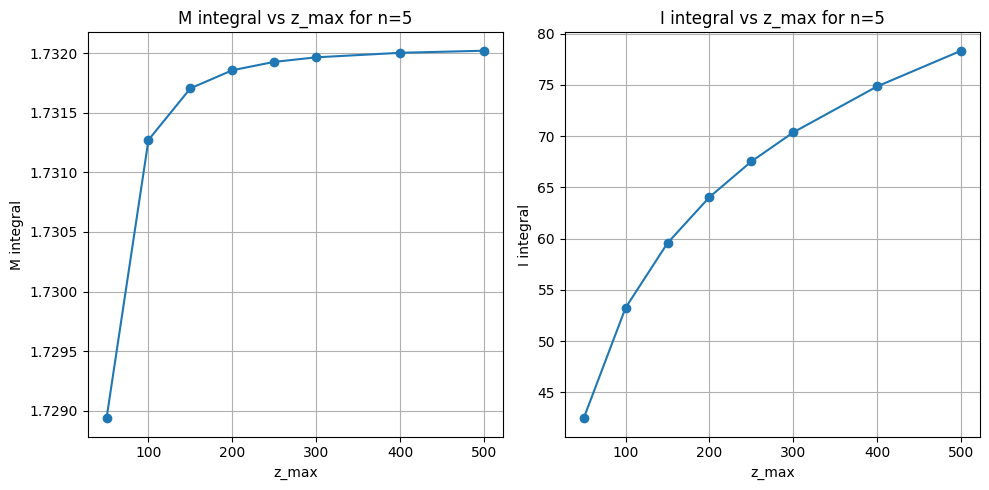

In [ ]:
for i, n in enumerate(ns):
    print(f"n={n}: z_zero={Rs[i]:.3f}, M_int={M_ints[i]:.4f}, I_int={I_ints[i]:.4f}")

for i, z_max in enumerate(n5_maxes):
    print(f"n=5, z_max={z_max}: M_int={n5_Ms[i]:.4f}, I_int={n5_Is[i]:.4f}")

# plot M and I for n=5 as a function of z_max
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n5_maxes, n5_Ms, marker='o')
plt.xlabel("z_max")
plt.ylabel("M integral")
plt.title("M integral vs z_max for n=5")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(n5_maxes, n5_Is, marker='o')
plt.xlabel("z_max")
plt.ylabel("I integral")
plt.title("I integral vs z_max for n=5")
plt.grid()

plt.tight_layout()
# plt.savefig("n5_M_I_vs_zmax.png", bbox_inches='tight', dpi=300)
plt.show()